## MOL


Starting ODE integration...
Integration finished in 0.97 seconds.
Total calls to PDE function: 370

--- Time =    0.0 days ---
  r (cm)              Nn              Nt              Ch
   0.000      5.0002e+07      9.9996e+04      9.9331e-10
   0.050      5.0335e+07      9.9337e+04      5.0000e-10
   0.100      7.5000e+07      5.0500e+04      6.6929e-12
   0.150      9.9665e+07      1.6626e+03      4.5398e-14
   0.200      9.9998e+07      1.0045e+03      3.0590e-16
   0.250      1.0000e+08      1.0000e+03      2.0612e-18
   0.300      1.0000e+08      1.0000e+03      1.3888e-20
   0.350      1.0000e+08      1.0000e+03      9.3592e-23
   0.400      1.0000e+08      1.0000e+03      6.1063e-25
   0.450      1.0000e+08      1.0000e+03      0.0000e+00
   0.500      1.0000e+08      1.0000e+03      0.0000e+00

--- Time =   11.6 days ---
  r (cm)              Nn              Nt              Ch
   0.000      4.9890e+07      2.7093e+05      5.1665e-09
   0.050      5.0021e+07      2.6916e+05      4

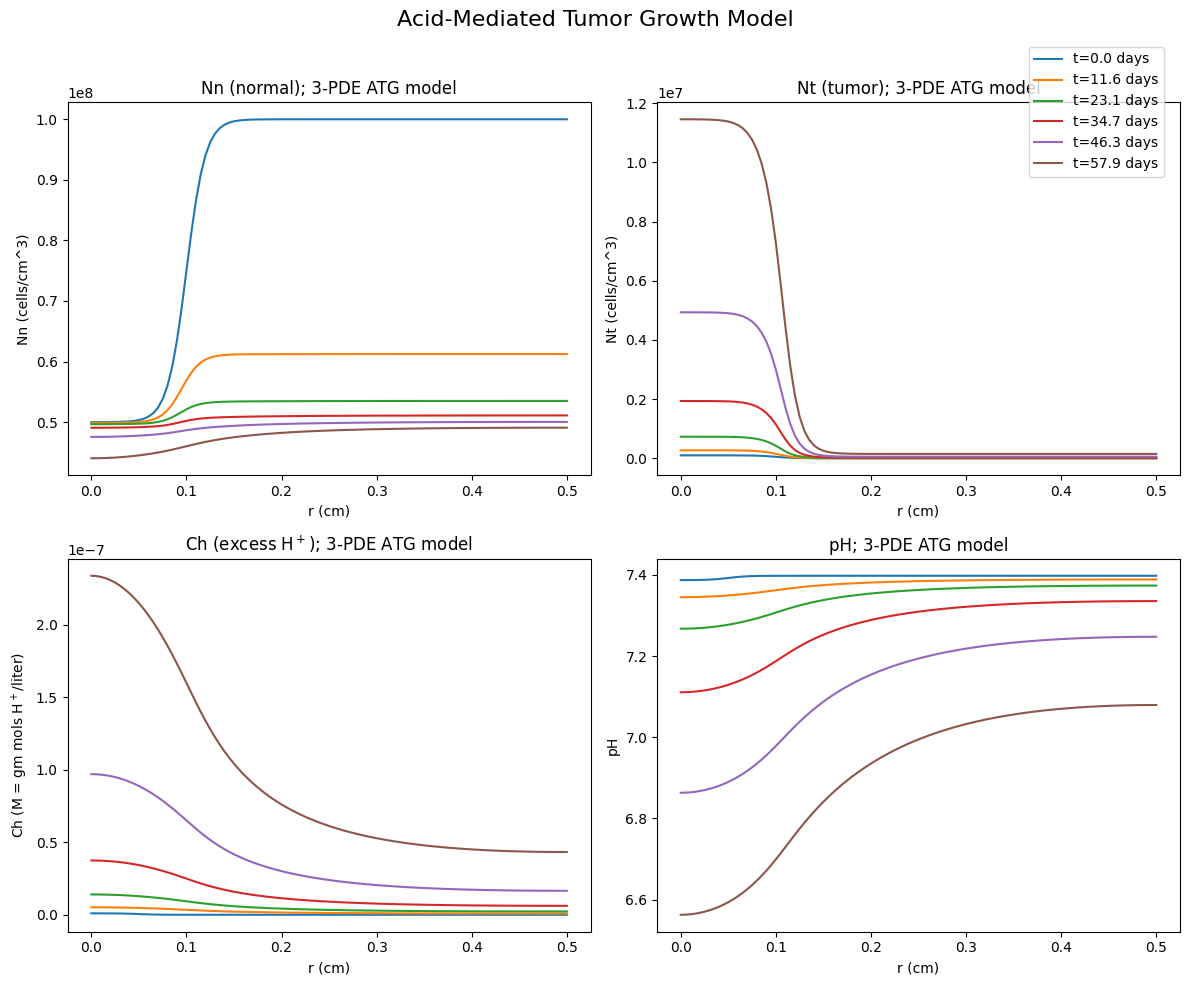

Saving simulation results to CSV...
All results saved.


In [21]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time
import pandas as pd  # <-- Added for CSV export

# A class to hold all model parameters to avoid using global variables
class ModelParameters:
    def __init__(self):
        # Grid parameters
        self.rl = 0.0
        self.ru = 0.5
        self.n = 101
        self.r = np.linspace(self.rl, self.ru, self.n)
        self.dr = self.r[1] - self.r[0]

        # Nn (Normal cells) PDE parameters
        self.rn1 = 1.0e-06
        self.rn2 = 1.0
        self.Kn = 5.0e+07

        # Nt (Tumor cells) PDE parameters
        self.rt1 = 1.0e-06
        self.Dt = 2.0e-10
        self.Kt = 5.0e+07

        # Ch (H+ concentration) PDE parameters
        self.rh1 = 2.2e-17
        self.rh2 = 1.1e-04
        self.Dh = 5.0e-06

        # Counter for function calls, similar to MATLAB's ncall
        self.ncall = 0

def pde_system(t, u, params):
    params.ncall += 1
    n = params.n
    Nn = u[0:n]
    Nt = u[n:2*n]
    Ch = u[2*n:3*n]

    Nnr = np.gradient(Nn, params.dr)
    Ntr = np.gradient(Nt, params.dr)
    Chr = np.gradient(Ch, params.dr)

    Ntr[0], Ntr[-1] = 0, 0
    Chr[0], Chr[-1] = 0, 0

    Ntrr = np.gradient(Ntr, params.dr)
    Chrr = np.gradient(Chr, params.dr)

    Nnt = np.zeros(n)
    Ntt = np.zeros(n)
    Cht = np.zeros(n)

    for i in range(n):
        D = params.Dt * (1 - Nn[i] / params.Kn)
        if D < 0:
            D = 0

        if i == 0:
            Nnt[i] = params.rn1 * Nn[i] * (1 - Nn[i] / params.Kn) - params.rn2 * Ch[i] * Nn[i]
            Ntt[i] = params.rt1 * Nt[i] * (1 - Nt[i] / params.Kt) + 3 * D * Ntrr[i]
            Cht[i] = params.rh1 * Nt[i] - params.rh2 * Ch[i] + 3 * params.Dh * Chrr[i]
        else:
            Nnt[i] = params.rn1 * Nn[i] * (1 - Nn[i] / params.Kn) - params.rn2 * Ch[i] * Nn[i]
            diffusion_term_Nt = D * (Ntrr[i] + 2/params.r[i] * Ntr[i]) + \
                                (-params.Dt/params.Kn) * Nnr[i] * Ntr[i]
            Ntt[i] = params.rt1 * Nt[i] * (1 - Nt[i] / params.Kt) + diffusion_term_Nt
            diffusion_term_Ch = params.Dh * (Chrr[i] + 2/params.r[i] * Chr[i])
            Cht[i] = params.rh1 * Nt[i] - params.rh2 * Ch[i] + diffusion_term_Ch

    return np.concatenate((Nnt, Ntt, Cht))

def get_initial_conditions(params):
    u0 = np.zeros(3 * params.n)
    r = params.r
    n = params.n

    rs = 50
    r_transition_cells = r[20]
    r_transition_H = r[10]

    tanhr_Nn = np.tanh(rs * (r - r_transition_cells))
    Nn_0 = 5.0e+07 * (1 - tanhr_Nn) / 2 + 1.0e+08 * (1 + tanhr_Nn) / 2

    tanhr_Nt = np.tanh(rs * (r - r_transition_cells))
    Nt_0 = 1.0e+05 * (1 - tanhr_Nt) / 2 + 1.0e+03 * (1 + tanhr_Nt) / 2

    tanhr_Ch = np.tanh(rs * (r - r_transition_H))
    Ch_0 = 1.0e-09 * (1 - tanhr_Ch) / 2 + 0 * (1 + tanhr_Ch) / 2

    u0[0:n] = Nn_0
    u0[n:2*n] = Nt_0
    u0[2*n:3*n] = Ch_0

    return u0

def run_and_plot():
    params = ModelParameters()
    ncase = 1

    if ncase == 1 or ncase == 3:
        t0 = 0.0
        tf = 5.0e+06
        nout = 6
        tout = np.linspace(t0, tf, nout)
    elif ncase == 2:
        t0 = 0.0
        tf = 5.0e+06
        nout = 21
        tout = np.linspace(t0, tf, nout)

    u0 = get_initial_conditions(params)

    print("Starting ODE integration...")
    start_time = time.time()

    sol = solve_ivp(
        pde_system,
        [t0, tf],
        u0,
        method='BDF',
        t_eval=tout,
        args=(params,)
    )

    end_time = time.time()
    print(f"Integration finished in {end_time - start_time:.2f} seconds.")
    print(f"Total calls to PDE function: {params.ncall}")

    if not sol.success:
        print("ODE solver failed:", sol.message)
        return

    u = sol.y.T
    Nn = u[:, 0:params.n]
    Nt = u[:, params.n:2*params.n]
    Ch = u[:, 2*params.n:3*params.n]

    for it in range(nout):
        print(f'\n--- Time = {tout[it]/(60*60*24):6.1f} days ---')
        print(f'{"r (cm)":>8} {"Nn":>15} {"Nt":>15} {"Ch":>15}')
        for i in range(0, params.n, 10):
            print(f'{params.r[i]:8.3f} {Nn[it, i]:15.4e} {Nt[it, i]:15.4e} {Ch[it, i]:15.4e}')

    if ncase == 1 or ncase == 3:
        pH = -np.log10(4.0e-08 + Ch)

        plt.style.use('default')
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('Acid-Mediated Tumor Growth Model', fontsize=16)

        axs[0, 0].set_title('Nn (normal); 3-PDE ATG model')
        for i in range(nout):
            axs[0, 0].plot(params.r, Nn[i, :], label=f't={tout[i]/(60*60*24):.1f} days')
        axs[0, 0].set_xlabel('r (cm)')
        axs[0, 0].set_ylabel('Nn (cells/cm^3)')

        axs[0, 1].set_title('Nt (tumor); 3-PDE ATG model')
        for i in range(nout):
            axs[0, 1].plot(params.r, Nt[i, :])
        axs[0, 1].set_xlabel('r (cm)')
        axs[0, 1].set_ylabel('Nt (cells/cm^3)')

        axs[1, 0].set_title('Ch (excess H$^+$); 3-PDE ATG model')
        for i in range(nout):
            axs[1, 0].plot(params.r, Ch[i, :])
        axs[1, 0].set_xlabel('r (cm)')
        axs[1, 0].set_ylabel('Ch (M = gm mols H$^+$/liter)')

        axs[1, 1].set_title('pH; 3-PDE ATG model')
        for i in range(nout):
            axs[1, 1].plot(params.r, pH[i, :])
        axs[1, 1].set_xlabel('r (cm)')
        axs[1, 1].set_ylabel('pH')

        fig.legend(loc='upper right', bbox_to_anchor=(0.98, 0.95))
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    # --- Save Results to CSV ---
    print("Saving simulation results to CSV...")

    for it in range(nout):
        df = pd.DataFrame({
            'r (cm)': params.r,
            'Nn': Nn[it, :],
            'Nt': Nt[it, :],
            'Ch': Ch[it, :],
            'pH': -np.log10(4.0e-08 + Ch[it, :])
        })

        day = tout[it] / (60 * 60 * 24)
        filename = f'simulation_day_{day:.1f}.csv'
        df.to_csv(filename, index=False)

    print("All results saved.")

if __name__ == '__main__':
    run_and_plot()


## Crank-Nichlson Method



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Model parameters
r_n1 = 1.0e-6    # Normal cell growth rate
r_n2 = 1.0       # Acid-induced death rate
r_t1 = 1.0e-6    # Tumor growth rate
r_h1 = 2.2e-17   # H+ production rate
r_h2 = 1.1e-4    # H+ decay rate
K_n = 5.0e7      # Normal cell capacity
K_t = 5.0e7      # Tumor cell capacity
D_t = 2.0e-10    # Tumor diffusivity
D_h = 5.0e-6     # H+ diffusivity

# Spatial grid
R = 0.5          # Domain radius [cm]
Nr = 101         # Number of spatial points
r = np.linspace(0, R, Nr)
dr = r[1] - r[0]

# Time parameters
dt = 1e4         # Time step
Nt = 500         # Number of time steps
t_final = Nt * dt

# Initialize fields and storage for time points
def initial_conditions(r):
    """Create initial conditions using tanh profile"""
    N_n = np.zeros_like(r)
    N_t = np.zeros_like(r)
    C_h = np.zeros_like(r)

    rs = 50  # Scaling factor
    r0_n = 0.1  # Transition point for normal cells
    r0_t = 0.1  # Transition point for tumor cells
    r0_h = 0.05  # Transition point for acid

    for i in range(len(r)):
        # Normal cells
        tanhr = np.tanh(rs*(r[i]-r0_n))
        N_n[i] = 5.0e7*(1-tanhr)/2 + 1.0e8*(1+tanhr)/2

        # Tumor cells
        tanhr = np.tanh(rs*(r[i]-r0_t))
        N_t[i] = 1.0e5*(1-tanhr)/2 + 1.0e3*(1+tanhr)/2

        # Acid concentration
        tanhr = np.tanh(rs*(r[i]-r0_h))
        C_h[i] = 1.0e-9*(1-tanhr)/2 + 0.0*(1+tanhr)/2

    return N_n, N_t, C_h

N_n, N_t, C_h = initial_conditions(r)

# Create storage for multiple time points
snapshot_times = [0, 100, 200, 300, 400, 499]  # Time indices to store
time_points = len(snapshot_times)
N_n_history = np.zeros((Nr, time_points))
N_t_history = np.zeros((Nr, time_points))
C_h_history = np.zeros((Nr, time_points))
pH_history = np.zeros((Nr, time_points))

# Store initial condition
N_n_history[:, 0] = N_n
N_t_history[:, 0] = N_t
C_h_history[:, 0] = C_h
pH_history[:, 0] = -np.log10(4.0e-8 + C_h)

# Create differentiation matrices for Crank-Nicolson
def create_diffusion_matrix(r, dr, D):
    """Create matrix for (1/r²)∂/∂r(r²D∂u/∂r)"""
    N = len(r)
    main_diag = np.zeros(N)
    lower_diag = np.zeros(N-1)
    upper_diag = np.zeros(N-1)

    for i in range(1, N-1):
        r_plus = r[i] + dr/2
        r_minus = r[i] - dr/2

        alpha = D[i] * r_plus**2 / (r[i]**2 * dr**2)
        beta = D[i] * r_minus**2 / (r[i]**2 * dr**2)

        lower_diag[i-1] = beta
        main_diag[i] = -(alpha + beta)
        upper_diag[i] = alpha

    # Boundary conditions
    # At r=0: use L'Hopital's rule (3*D*d²u/dr²)
    main_diag[0] = -3 * D[0] / dr**2
    upper_diag[0] = 3 * D[0] / dr**2

    # At r=R: Neumann BC (du/dr = 0)
    main_diag[-1] = 1
    lower_diag[-1] = -1

    return diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], format='csc')

# Time-stepping with Crank-Nicolson
for n in range(1, Nt):
    # Compute variable diffusion coefficient
    D = D_t * (1 - N_n/K_n)
    D[D < 0] = 0

    # Create matrices for tumor and acid equations
    A_tumor = create_diffusion_matrix(r, dr, D)
    A_acid = create_diffusion_matrix(r, dr, D_h * np.ones_like(r))

    # Identity matrix
    I = diags([np.ones(Nr)], [0], format='csc')

    # --- Normal cells (ODE, solved implicitly) ---
    reaction_old = r_n1 * N_n * (1 - N_n/K_n) - r_n2 * C_h * N_n
    # Predict new N_n with Euler step for nonlinear terms
    N_n_pred = N_n + dt * reaction_old
    reaction_new = r_n1 * N_n_pred * (1 - N_n_pred/K_n) - r_n2 * C_h * N_n_pred
    N_n = N_n + 0.5 * dt * (reaction_old + reaction_new)

    # --- Tumor cells (PDE) ---
    reaction_old = r_t1 * N_t * (1 - N_t/K_t)
    # Predict new N_t with Euler step for nonlinear terms
    N_t_pred = N_t + dt * (reaction_old + A_tumor.dot(N_t))
    reaction_new = r_t1 * N_t_pred * (1 - N_t_pred/K_t)

    # Crank-Nicolson system
    lhs = I - 0.5 * dt * A_tumor
    rhs = N_t + 0.5 * dt * (reaction_old + reaction_new + A_tumor.dot(N_t))
    N_t = spsolve(lhs, rhs)

    # --- Acid concentration (PDE) ---
    reaction_old = r_h1 * N_t - r_h2 * C_h
    # Predict new C_h with Euler step for nonlinear terms
    C_h_pred = C_h + dt * (reaction_old + A_acid.dot(C_h))
    reaction_new = r_h1 * N_t - r_h2 * C_h_pred

    # Crank-Nicolson system
    lhs = I - 0.5 * dt * A_acid
    rhs = C_h + 0.5 * dt * (reaction_old + reaction_new + A_acid.dot(C_h))
    C_h = spsolve(lhs, rhs)

    # Apply boundary conditions explicitly
    N_t[0] = N_t[1]   # Symmetry at r=0
    N_t[-1] = N_t[-2]  # No flux at r=R
    C_h[0] = C_h[1]    # Symmetry at r=0
    C_h[-1] = C_h[-2]  # No flux at r=R

    # Store solutions at specified time points
    if n in snapshot_times[1:]:
        idx = snapshot_times.index(n)
        N_n_history[:, idx] = N_n
        N_t_history[:, idx] = N_t
        C_h_history[:, idx] = C_h
        pH_history[:, idx] = -np.log10(4.0e-8 + C_h)

    # Print progress
    if n % 50 == 0:
        print(f"Time step {n}, t = {n*dt/(24*3600):.2f} days")

# Plot results with multiple time points
plt.figure(figsize=(15, 12))
colors = plt.cm.viridis(np.linspace(0, 1, time_points))

# Normal cells
plt.subplot(2, 2, 1)
for i in range(time_points):
    plt.plot(r, N_n_history[:, i], color=colors[i],
             label=f't = {snapshot_times[i]*dt/(24*3600):.1f} days')
plt.xlabel('r (cm)')
plt.ylabel('Nn (cells/cm³)')
plt.title('Normal Cell Density Evolution')
plt.legend()
plt.grid(True)

# Tumor cells
plt.subplot(2, 2, 2)
for i in range(time_points):
    plt.plot(r, N_t_history[:, i], color=colors[i],
             label=f't = {snapshot_times[i]*dt/(24*3600):.1f} days')
plt.xlabel('r (cm)')
plt.ylabel('Nt (cells/cm³)')
plt.title('Tumor Cell Density Evolution')
plt.legend()
plt.grid(True)

# Acid concentration (linear scale)
plt.subplot(2, 2, 3)
for i in range(time_points):
    plt.plot(r, C_h_history[:, i], color=colors[i],
             label=f't = {snapshot_times[i]*dt/(24*3600):.1f} days')
plt.xlabel('r (cm)')
plt.ylabel('H+ Concentration (M)')
plt.title('Acid Concentration Evolution (Linear Scale)')
plt.legend()
plt.grid(True)

# pH
plt.subplot(2, 2, 4)
for i in range(time_points):
    plt.plot(r, pH_history[:, i], color=colors[i],
             label=f't = {snapshot_times[i]*dt/(24*3600):.1f} days')
plt.xlabel('r (cm)')
plt.ylabel('pH')
plt.title('pH Evolution')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Finite Element Method

,t,r,N_n,N_t,C_h,pH
0,0.0,0.000,5.000227e+07,99995.505611,9.933071e-10,7.389297
1,0.0,0.005,5.000374e+07,99992.590223,9.890131e-10,7.389343
2,0.0,0.010,5.000617e+07,99987.783937,9.820138e-10,7.389417
3,0.0,0.015,5.001017e+07,99979.860729,9.706878e-10,7.389538
4,0.0,0.020,5.001677e+07,99966.800337,9.525741e-10,7.389731
...,...,...,...,...,...,...
601,5002558.0,0.480,4.895502e+07,148350.482602,4.248911e-08,7.084601
602,5002558.0,0.485,4.895571e+07,148350.482605,4.246290e-08,7.084739
603,5002558.0,0.490,4.895619e+07,148350.482603,4.244440e-08,7.084837
604,5002558.0,0.495,4.895648e+07,148350.482604,4.243342e-08,7.084895


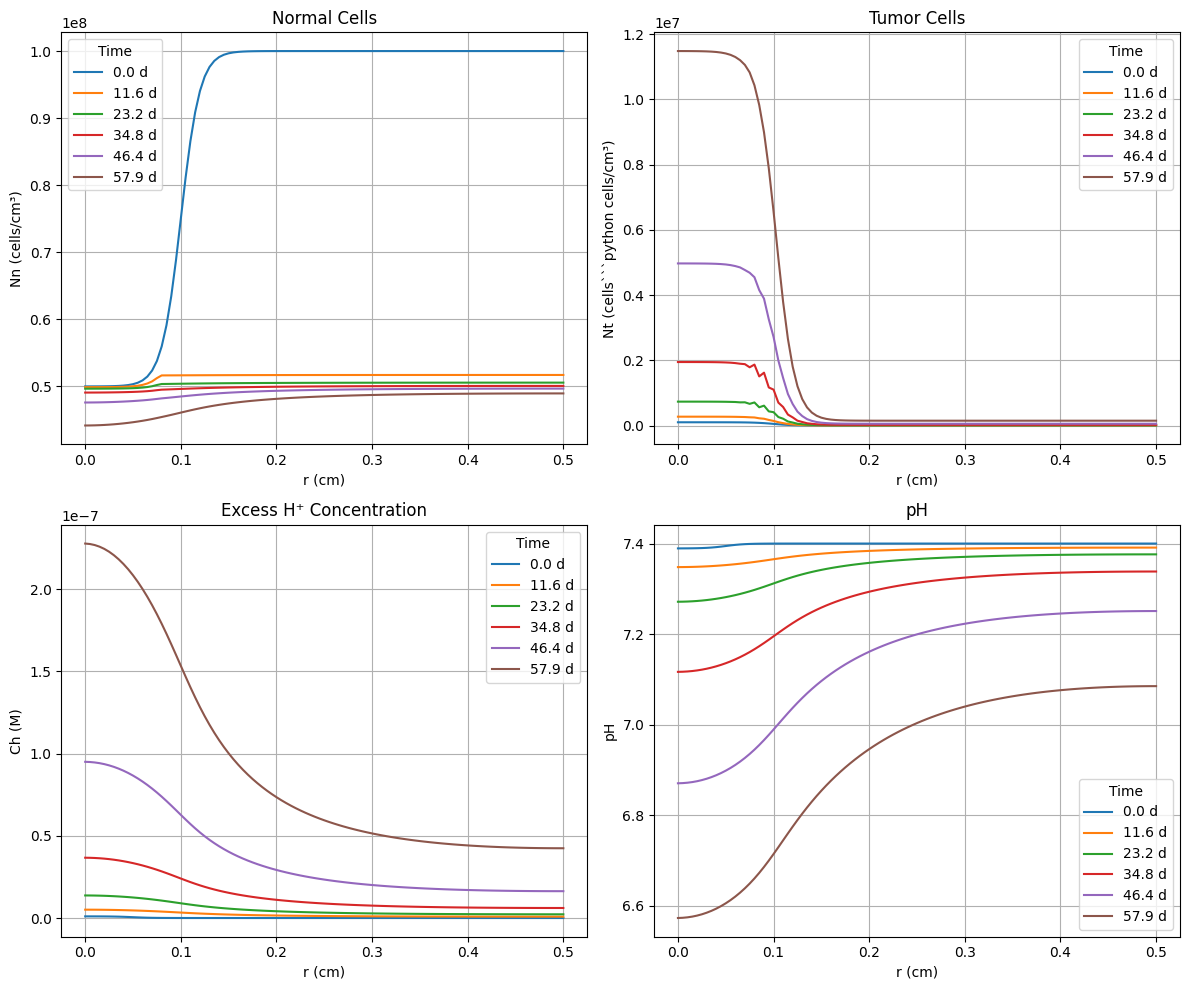

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

# Constants
r_n1 = 1.0e-6
r_n2 = 1.0
r_t1 = 1.0e-6
r_h1 = 2.2e-17
r_h2 = 1.1e-4
K_n = 5.0e7
K_t = 5.0e7
D_t = 2.0e-10
D_h = 5.0e-6
baseline = 10**(-7.4)
r_s = 50
r_21 = 0.1 # 0.09375
r_11=0.05 #0.103125


# Domain Setup
R = 0.5
N = 100
r = np.linspace(0, R, N+1)
h = r[1] - r[0]

T = 5.00256e6
dt = 11.6
steps = int(np.ceil(T / dt))

output_times = np.array([0, 11.6, 23.2, 34.8, 46.4, 57.9]) * 86400

output_steps = []
for t_out in output_times[1:]:
    steps_array = np.arange(steps)
    t_array = (steps_array + 1) * dt
    step = np.argmin(np.abs(t_array - t_out))
    output_steps.append(step)
output_steps_set = set(output_steps)

# Initial conditions

tanh_r = np.tanh(r_s * (r - r_21))
Nn = 5.0e7 * (1 - tanh_r) / 2 + 1.0e8 * (1 + tanh_r) / 2
Nt = 1.0e5 * (1 - tanh_r) / 2 + 1.0e3 * (1 + tanh_r) / 2

tanh_r = np.tanh(r_s * (r - r_11))
Ch = 1e-9 * (1 - tanh_r) / 2

# # Stiffness Matrix

def stiffness_matrix(w):
    w_avg = (w[:-1] + w[1:]) / 2
    diag = np.zeros(N + 1)
    diag[0] = w_avg[0] / h
    diag[1:-1] = (w_avg[:-1] + w_avg[1:]) / h
    diag[-1] = w_avg[-1] / h
    off_diag = -w_avg / h
    return diags([off_diag, diag, off_diag], [-1, 0, 1], shape=(N + 1, N + 1))

# Mass Matrix F

diag = np.zeros(N + 1)
off_diag = np.zeros(N)

for i in range(1, N):
    r_m_left = (r[i - 1] + r[i]) / 2
    r_m_right = (r[i] + r[i + 1]) / 2
    diag[i] = (h / 3) * (r_m_left**2 + r_m_right**2)

diag[0] = (h / 3) * ((r[0] + r[1]) / 2)**2
diag[N] = (h / 3) * ((r[N - 1] + r[N]) / 2)**2

for i in range(N):
    r_m = (r[i] + r[i + 1]) / 2
    off_diag[i] = (h / 6) * r_m**2
F = diags([off_diag, diag, off_diag], [-1, 0, 1], shape=(N + 1, N + 1))

# Appending the inital state
data = []

for i, ri in enumerate(r):
    pH = -np.log10(baseline + np.clip(Ch[i], 0, None))
    data.append([0.0, ri, Nn[i], Nt[i], Ch[i], pH])


for step in range(steps):
    t = (step + 1) * dt

    Nn_curr = Nn.copy()
    Nt_curr = Nt.copy()
    Ch_curr = Ch.copy()

    f_Nn = r_n1 * Nn_curr * (1 - Nn_curr / K_n) - r_n2 * Ch_curr * Nn_curr
    f_Nt = r_t1 * Nt_curr * (1 - Nt_curr / K_t)
    f_Ch = r_h1 * Nt_curr - r_h2 * Ch_curr

    D_Nn = D_t * (1 - Nn_curr / K_n)
    w_Nt = D_Nn * r**2
    K_Nt = stiffness_matrix(w_Nt)
    A_Nt = F + dt * K_Nt
    b_Nt = F @ Nt_curr + dt * F @ f_Nt
    Nt = spsolve(csc_matrix(A_Nt), b_Nt)

    w_Ch = D_h * r**2
    K_Ch = stiffness_matrix(w_Ch)
    A_Ch = F + dt * K_Ch
    b_Ch = F @ Ch_curr + dt * F @ f_Ch
    Ch = spsolve(csc_matrix(A_Ch), b_Ch)

    Nn = Nn_curr + dt * f_Nn

    Nn = np.clip(Nn, 0, 1.1 * K_n)
    Nt = np.clip(Nt, 0, 1.1 * K_t)
    Ch = np.clip(Ch, 0, 1e-6)

    if step in output_steps_set:
        for i, ri in enumerate(r):
            pH = -np.log10(baseline + np.clip(Ch[i], 0, None))
            data.append([t, ri, Nn[i], Nt[i], Ch[i], pH])

df = pd.DataFrame(data, columns=['t', 'r', 'N_n', 'N_t', 'C_h', 'pH'])

# O(1)
df.to_csv('FEM.csv', index=False)

# Display Output
display(df)

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
for t in output_times:
    df_t = df[np.isclose(df['t'], t, atol=dt)]

    if not df_t.empty:
        plt.plot(df_t['r'], df_t['N_n'], label=f'{t / (3600*24):.1f} d')

plt.xlabel('r (cm)')
plt.ylabel('Nn (cells/cm³)')
plt.title('Normal Cells')
plt.legend(title='Time')
plt.grid(True)

plt.subplot(2, 2, 2)
for t in output_times:
    df_t = df[np.isclose(df['t'], t, atol=dt)]

    if not df_t.empty:
        plt.plot(df_t['r'], df_t['N_t'], label=f'{t / (3600*24):.1f} d')

plt.xlabel('r (cm)')
plt.ylabel('Nt (cells```python cells/cm³)')
plt.title('Tumor Cells')
plt.legend(title='Time')
plt.grid(True)

plt.subplot(2, 2, 3)
for t in output_times:
    df_t = df[np.isclose(df['t'], t, atol=dt)]

    if not df_t.empty:
        plt.plot(df_t['r'], df_t['C_h'], label=f'{t / (3600*24):.1f} d')

plt.xlabel('r (cm)')
plt.ylabel('Ch (M)')
plt.title('Excess H⁺ Concentration')
plt.legend(title='Time')
plt.grid(True)

plt.subplot(2, 2, 4)
for t in output_times:
    df_t = df[np.isclose(df['t'], t, atol=dt)]

    if not df_t.empty:
        plt.plot(df_t['r'], df_t['pH'], label=f'{t / (3600*24):.1f} d')

plt.xlabel('r (cm)')
plt.ylabel('pH')
plt.title('pH')
plt.legend(title='Time')
plt.grid(True)

plt.tight_layout()
plt.show()

## Pseudo-Spectral Method

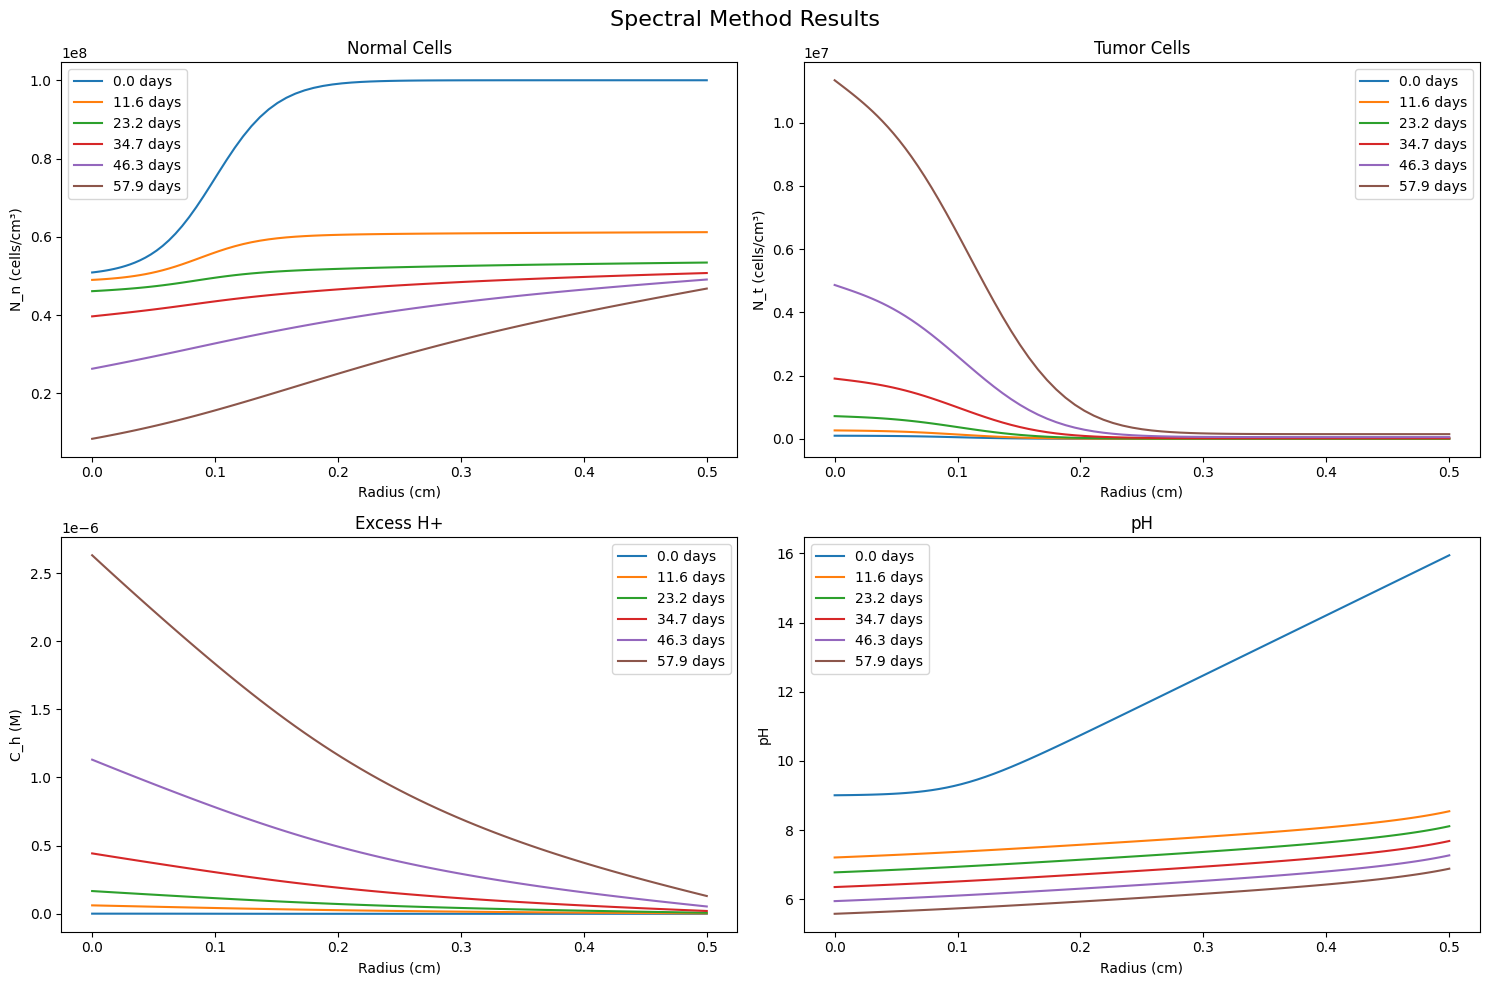

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


r_n1 = 1.0e-6    # Normal cell growth rate
r_n2 = 1.0       # Acid-induced death rate
r_t1 = 1.0e-6    # Tumor growth rate
r_h1 = 2.2e-17   # H+ production rate
r_h2 = 1.1e-4    # H+ decay rate
K_n = 5.0e7      # Normal cell capacity
K_t = 5.0e7      # Tumor cell capacity
D_t = 2.0e-10    # Tumor diffusivity
D_h = 5.0e-6     # H+ diffusivity

#Chebychev Grid
N = 100
k = np.arange(N+1)
R = 0.5
r = R * (1 - np.cos(np.pi * k / N)) / 2

def cheb_diff_matrix(N, R):
    x = np.cos(np.pi * np.arange(N+1) / N)  # [-1, 1]
    c = np.ones(N+1)
    c[0] = c[-1] = 2
    D = np.zeros((N+1, N+1))
    for i in range(N+1):
        for j in range(N+1):
            if i != j:
                D[i, j] = (-1)**(i + j) * c[i] / (c[j] * (x[i] - x[j]))
            elif i == j == 0:
                D[i, j] = (2 * N**2 + 1) / 6
            elif i == j == N:
                D[i, j] = -(2 * N**2 + 1) / 6
            else:
                D[i, j] = -x[i] / (2 * (1 - x[i]**2))
    return (2 / R) * D

D1 = cheb_diff_matrix(N, R)
D2 = D1 @ D1

# Neumann BCs
D2_bc = D2.copy()
D2_bc[0, :] = D1[0, :]
D2_bc[-1, :] = D1[-1, :]

# === Initial Conditions ===
tanh_r = np.tanh(20 * (r - 0.1))  # softened transition
N_n0 = 5.0e7 * (1 - tanh_r) / 2 + 1.0e8 * (1 + tanh_r) / 2
N_t0 = 1.0e5 * (1 - tanh_r) / 2 + 1.0e3 * (1 + tanh_r) / 2
C_h0 = 1.0e-9 * (1 - tanh_r) / 2

y0 = np.concatenate([N_n0, N_t0, C_h0])

def tumor_rhs(t, y):
    N_n = y[:N+1]
    N_t = y[N+1:2*(N+1)]
    C_h = y[2*(N+1):]

    # Clip to prevent overflow/NaNs
    N_n = np.clip(N_n, 0, 1e9)
    N_t = np.clip(N_t, 0, 1e9)
    C_h = np.clip(C_h, 0, 1e-3)

    # Reactions
    dNn = r_n1 * N_n * (1 - N_n / K_n) - r_n2 * C_h * N_n
    dNt = r_t1 * N_t * (1 - N_t / K_t)
    dCh = r_h1 * N_t - r_h2 * C_h

    # Diffusion
    dNt += D_t * (D2_bc @ N_t)
    dCh += D_h * (D2_bc @ C_h)

    return np.concatenate([dNn, dNt, dCh])

t_span = (0, 5.00256e6)
t_eval = np.linspace(*t_span, 6)

sol = solve_ivp(
    tumor_rhs, t_span, y0, t_eval=t_eval,
    method='BDF', rtol=1e-6, atol=1e-9, max_step=1e5
)


N_n_plot = sol.y[:N+1]
N_t_plot = sol.y[N+1:2*(N+1)]
C_h_plot = sol.y[2*(N+1):]
pH_plot = -np.log10(np.clip(C_h_plot, 1e-20, None))

# === 2D Plots ===
plt.figure(figsize=(15, 10))
plt.suptitle('Spectral Method Results', fontsize=16)

def plot_field(subplot, data, title, ylabel):
    plt.subplot(2, 2, subplot)
    for i, t in enumerate(sol.t):
        plt.plot(r, data[:, i], label=f'{t/(24*3600):.1f} days')
    plt.title(title)
    plt.xlabel('Radius (cm)')
    plt.ylabel(ylabel)
    plt.legend()

plot_field(1, N_n_plot, 'Normal Cells', 'N_n (cells/cm³)')
plot_field(2, N_t_plot, 'Tumor Cells', 'N_t (cells/cm³)')
plot_field(3, C_h_plot, 'Excess H+', 'C_h (M)')
plot_field(4, pH_plot, 'pH', 'pH')

plt.tight_layout()
plt.show()

## PINN (Physics Informed Neural Network)

--- Starting PINN Training with TensorFlow ---
--- Running Numerical Solver to Generate Ground Truth Data ---
Noisy ground truth data saved to tumor_growth_data.csv

Epoch 0: Total Loss: 1.1462e+02, Data: 1.5034e-01, IC: 2.2760e-01, BC: 9.2049e-03, PDE: 2.7605e+01
Epoch 200: Total Loss: 2.0606e+01, Data: 3.4223e-02, IC: 5.7183e-02, BC: 4.4833e-03, PDE: 4.1120e-01
Epoch 400: Total Loss: 1.7762e+01, Data: 2.9403e-02, IC: 4.4582e-02, BC: 7.9016e-03, PDE: 4.3611e-01
Epoch 600: Total Loss: 8.8394e+00, Data: 1.3134e-02, IC: 3.2364e-02, BC: 2.9493e-03, PDE: 5.0659e-01
Epoch 800: Total Loss: 6.8906e+00, Data: 1.0322e-02, IC: 2.2592e-02, BC: 6.8301e-04, PDE: 5.6585e-01
Epoch 1000: Total Loss: 6.1059e+00, Data: 9.5129e-03, IC: 1.6739e-02, BC: 4.2744e-04, PDE: 4.9108e-01
Epoch 1200: Total Loss: 5.5734e+00, Data: 8.9450e-03, IC: 1.3353e-02, BC: 2.2674e-04, PDE: 4.2190e-01
Epoch 1400: Total Loss: 5.1345e+00, Data: 8.4521e-03, IC: 1.0943e-02, BC: 8.4528e-05, PDE: 3.5712e-01
Epoch 1600: Total Loss: 4

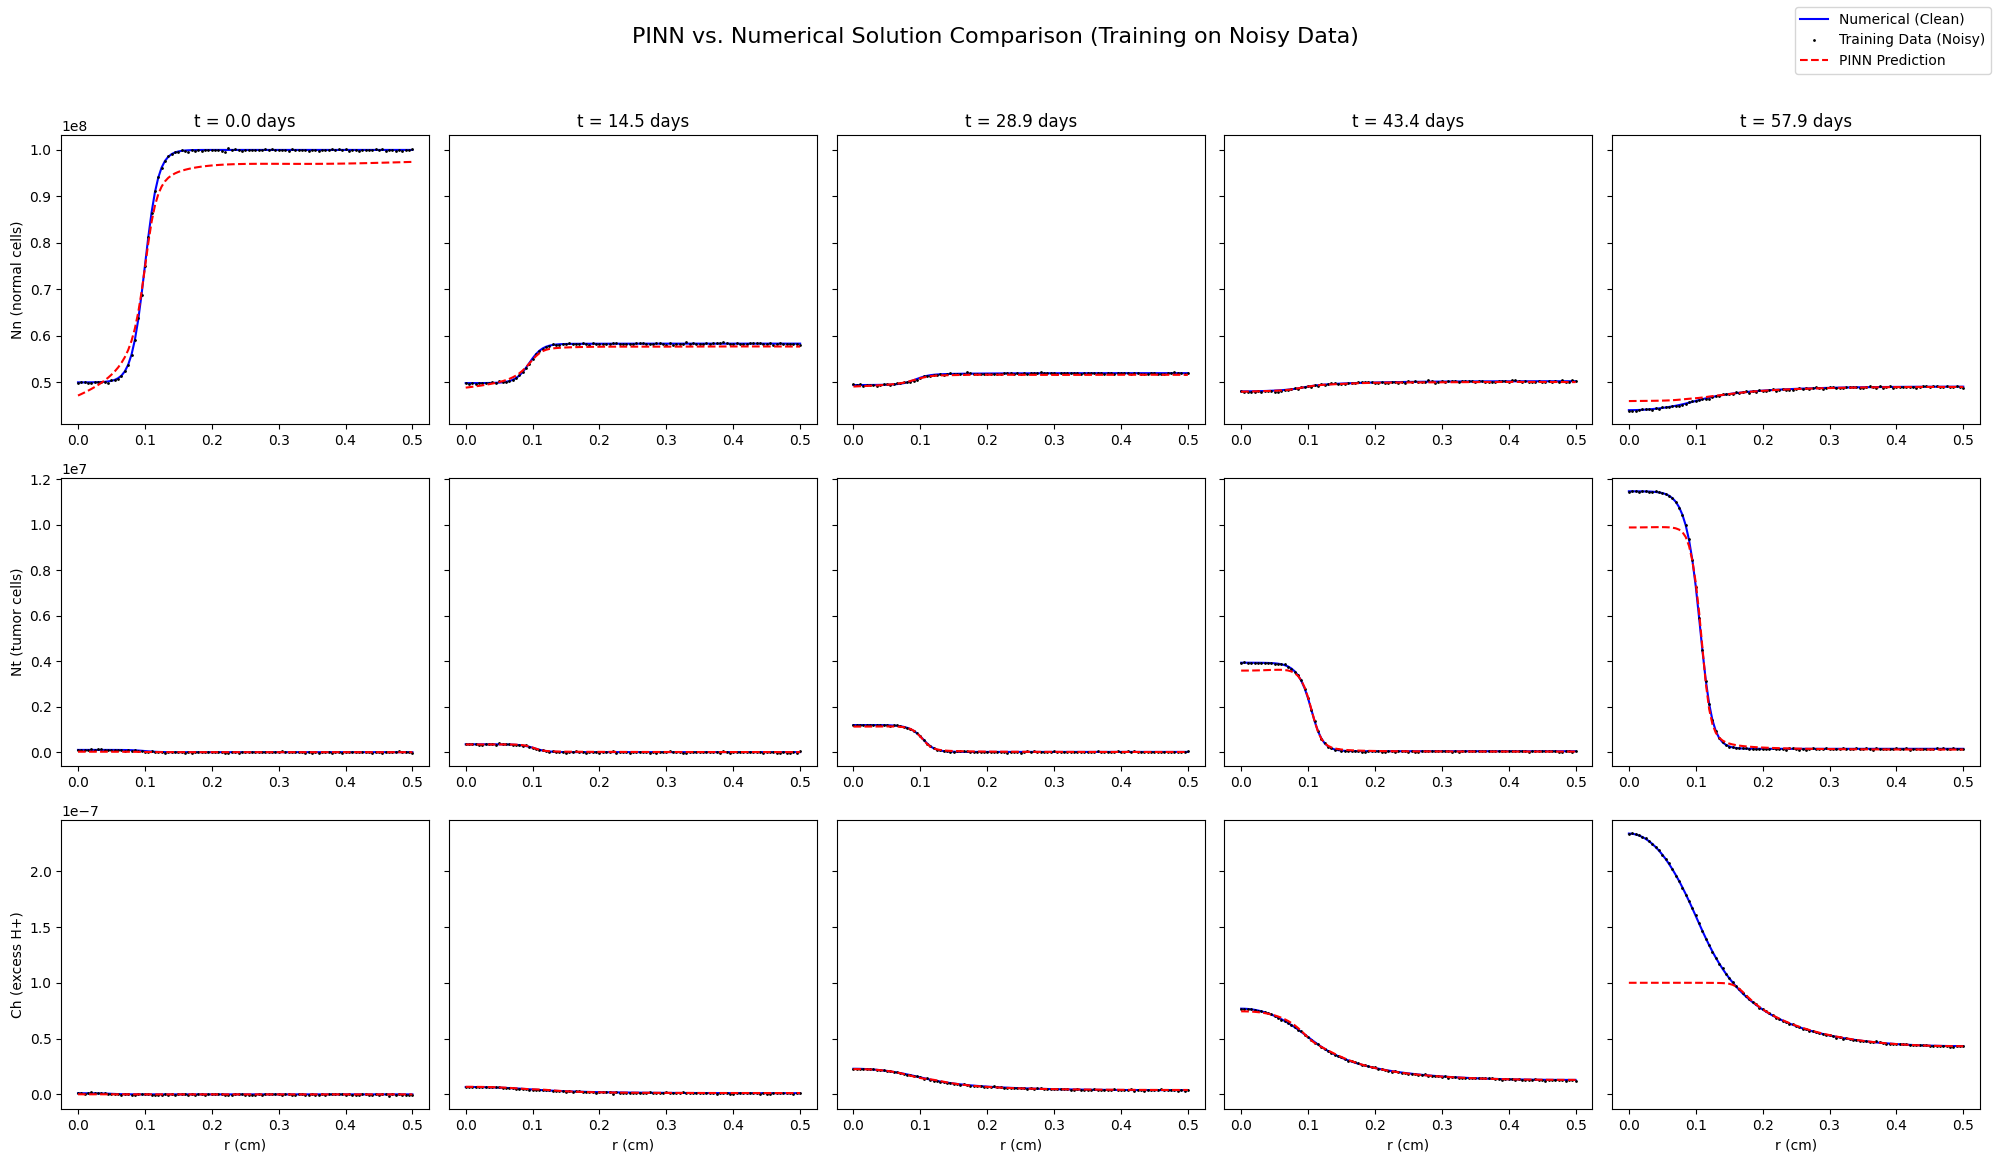

Plot saved as pinn_comparison.png


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time
import csv
import tensorflow as tf
import os

class ModelParameters:
    def __init__(self):
        # Grid and model parameters
        self.rl, self.ru, self.n = 0.0, 0.5, 101
        self.r = np.linspace(self.rl, self.ru, self.n)
        self.dr = self.r[1] - self.r[0]
        self.rn1, self.rn2, self.Kn = 1.0e-06, 1.0, 5.0e+07
        self.rt1, self.Dt, self.Kt = 1.0e-06, 2.0e-10, 5.0e+07
        self.rh1, self.rh2, self.Dh = 2.2e-17, 1.1e-04, 5.0e-06
        self.ncall = 0

        # Characteristic scales for normalization
        self.Nn_scale = 1.0e+08
        self.Nt_scale = 1.0e+07
        self.Ch_scale = 1.0e-07
        self.t_scale = 5.0e+06
        self.r_scale = 0.5

        # Add minimum radius to avoid division by zero
        self.r_min = 1e-8

def numerical_pde_system(t, u, params):
    params.ncall += 1
    n = params.n
    Nn, Nt, Ch = u[0:n], u[n:2*n], u[2*n:3*n]

    Nnr, Ntr, Chr = np.gradient(Nn, params.dr), np.gradient(Nt, params.dr), np.gradient(Ch, params.dr)
    Ntr[0], Ntr[-1] = 0, 0  # Boundary conditions
    Chr[0], Chr[-1] = 0, 0  # Boundary conditions

    Ntrr, Chrr = np.gradient(Ntr, params.dr), np.gradient(Chr, params.dr)

    Nnt, Ntt, Cht = np.zeros(n), np.zeros(n), np.zeros(n)

    for i in range(n):
        D = params.Dt * (1 - Nn[i] / params.Kn)
        if D < 0: D = 0

        Nnt[i] = params.rn1 * Nn[i] * (1 - Nn[i] / params.Kn) - params.rn2 * Ch[i] * Nn[i]
        if i == 0:
            Ntt[i] = params.rt1 * Nt[i] * (1 - Nt[i] / params.Kt) + 3 * D * Ntrr[i]
            Cht[i] = params.rh1 * Nt[i] - params.rh2 * Ch[i] + 3 * params.Dh * Chrr[i]
        else:
            diffusion_Nt = D * (Ntrr[i] + 2/params.r[i] * Ntr[i]) + (-params.Dt/params.Kn) * Nnr[i] * Ntr[i]
            Ntt[i] = params.rt1 * Nt[i] * (1 - Nt[i] / params.Kt) + diffusion_Nt
            diffusion_Ch = params.Dh * (Chrr[i] + 2/params.r[i] * Chr[i])
            Cht[i] = params.rh1 * Nt[i] - params.rh2 * Ch[i] + diffusion_Ch

    return np.concatenate((Nnt, Ntt, Cht))

def get_initial_conditions(params):
    r, n = params.r, params.n
    u0 = np.zeros(3 * n)
    rs = 50
    r_transition_cells, r_transition_H = r[20], r[10]

    tanhr_Nn = np.tanh(rs * (r - r_transition_cells))
    u0[0:n] = 5.0e+07 * (1 - tanhr_Nn) / 2 + 1.0e+08 * (1 + tanhr_Nn) / 2

    tanhr_Nt = np.tanh(rs * (r - r_transition_cells))
    u0[n:2*n] = 1.0e+05 * (1 - tanhr_Nt) / 2 + 1.0e+03 * (1 + tanhr_Nt) / 2

    tanhr_Ch = np.tanh(rs * (r - r_transition_H))
    u0[2*n:3*n] = 1.0e-09 * (1 - tanhr_Ch) / 2
    return u0

def generate_ground_truth_data(params):
    print("--- Running Numerical Solver to Generate Ground Truth Data ---")
    t0, tf, nout = 0.0, 5.0e+06, 21
    tout = np.linspace(t0, tf, nout)
    u0 = get_initial_conditions(params)

    sol = solve_ivp(numerical_pde_system, [t0, tf], u0, method='BDF', t_eval=tout, args=(params,))

    if not sol.success:
        raise RuntimeError("Numerical ODE solver failed:", sol.message)

    u = sol.y.T
    Nn, Nt, Ch = u[:, :params.n], u[:, params.n:2*params.n], u[:, 2*params.n:3*params.n]

    noise_level = 0.01 # 1% noise
    Nn_noisy = Nn + noise_level * np.std(Nn) * np.random.randn(*Nn.shape)
    Nt_noisy = Nt + noise_level * np.std(Nt) * np.random.randn(*Nt.shape)
    Ch_noisy = Ch + noise_level * np.std(Ch) * np.random.randn(*Ch.shape)

    csv_filename = 'tumor_growth_data.csv'
    with open(csv_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['t', 'r', 'Nn', 'Nt', 'Ch'])
        for it, t_val in enumerate(tout):
            for i, r_val in enumerate(params.r):
                writer.writerow([t_val, r_val, Nn_noisy[it, i], Nt_noisy[it, i], Ch_noisy[it, i]])
    print(f"Noisy ground truth data saved to {csv_filename}\n")
    return tout, params.r, Nn, Nt, Ch, Nn_noisy, Nt_noisy, Ch_noisy

class PINN(tf.keras.Model):
    def __init__(self, layers, params):
        super(PINN, self).__init__()
        self.params = params
        self.hidden = []
        for units in layers[1:-1]:
            layer = tf.keras.layers.Dense(
                units,
                activation='tanh',
                kernel_initializer='glorot_normal',
                bias_initializer='zeros'
            )
            self.hidden.append(layer)

        self.output_layer = tf.keras.layers.Dense(
            layers[-1],
            kernel_initializer='glorot_normal',
            bias_initializer='zeros',
            activation=None
        )

    def call(self, inputs):
        t, r = inputs[:, 0:1], inputs[:, 1:2]
        t_norm = t / self.params.t_scale
        r_norm = r / self.params.r_scale
        x = tf.concat([t_norm, r_norm], axis=1)

        for layer in self.hidden:
            x = layer(x)
        u_raw = self.output_layer(x)

        # Apply sigmoid activation to ensure positive outputs
        u_scaled = tf.nn.sigmoid(u_raw)
        return u_scaled

def safe_gradient(model, inputs, output_idx):
    """Compute gradient of specific output with respect to inputs"""
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        outputs = model(inputs)
        target_output = outputs[:, output_idx:output_idx+1]

    gradients = tape.gradient(target_output, inputs)
    if gradients is None:
        gradients = tf.zeros_like(inputs)
    return gradients

def get_pde_residuals(model, t, r, params):
    epsilon = 1e-8
    t_tensor = tf.convert_to_tensor(t, dtype=tf.float32)
    r_tensor = tf.convert_to_tensor(r, dtype=tf.float32)

    # Ensure r is never exactly zero
    r_tensor = tf.maximum(r_tensor, epsilon)

    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t_tensor, r_tensor])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([t_tensor, r_tensor])

            inputs = tf.concat([t_tensor, r_tensor], axis=1)
            u_scaled = model(inputs)

            # Scale back to physical units
            Nn = u_scaled[:, 0:1] * params.Nn_scale
            Nt = u_scaled[:, 1:2] * params.Nt_scale
            Ch = u_scaled[:, 2:3] * params.Ch_scale

        # First derivatives
        Nn_t = tape2.gradient(Nn, t_tensor)
        Nt_t = tape2.gradient(Nt, t_tensor)
        Ch_t = tape2.gradient(Ch, t_tensor)

        Nn_r = tape2.gradient(Nn, r_tensor)
        Nt_r = tape2.gradient(Nt, r_tensor)
        Ch_r = tape2.gradient(Ch, r_tensor)

    # Second derivatives
    Nt_rr = tape1.gradient(Nt_r, r_tensor)
    Ch_rr = tape1.gradient(Ch_r, r_tensor)

    # Clean up tapes
    del tape1, tape2

    # Check for None gradients and handle them
    if Nn_t is None: Nn_t = tf.zeros_like(Nn)
    if Nt_t is None: Nt_t = tf.zeros_like(Nt)
    if Ch_t is None: Ch_t = tf.zeros_like(Ch)
    if Nn_r is None: Nn_r = tf.zeros_like(Nn)
    if Nt_r is None: Nt_r = tf.zeros_like(Nt)
    if Ch_r is None: Ch_r = tf.zeros_like(Ch)
    if Nt_rr is None: Nt_rr = tf.zeros_like(Nt)
    if Ch_rr is None: Ch_rr = tf.zeros_like(Ch)

    # Add small epsilon to prevent division by zero
    Nn = tf.maximum(Nn, epsilon)
    Nt = tf.maximum(Nt, epsilon)
    Ch = tf.maximum(Ch, epsilon)

    # PDE residuals with improved numerical stability
    f_Nn = Nn_t - (params.rn1 * Nn * (1 - Nn / params.Kn) - params.rn2 * Ch * Nn)

    # Diffusion coefficient with better bounds
    D = tf.maximum(params.Dt * (1 - Nn / params.Kn), 0.0)

    # Handle r=0 case more carefully
    r_safe = tf.maximum(r_tensor, epsilon)

    # Diffusion terms with safer computation
    diffusion_Nt = D * (Nt_rr + 2.0 / r_safe * Nt_r)
    diffusion_Ch = params.Dh * (Ch_rr + 2.0 / r_safe * Ch_r)

    # Special case for r ≈ 0 (use L'Hôpital's rule result)
    is_near_zero = tf.less(r_tensor, epsilon * 100)
    diffusion_Nt_r0 = 3.0 * D * Nt_rr
    diffusion_Ch_r0 = 3.0 * params.Dh * Ch_rr

    diffusion_Nt = tf.where(is_near_zero, diffusion_Nt_r0, diffusion_Nt)
    diffusion_Ch = tf.where(is_near_zero, diffusion_Ch_r0, diffusion_Ch)

    f_Nt = Nt_t - (params.rt1 * Nt * (1 - Nt / params.Kt) + diffusion_Nt)
    f_Ch = Ch_t - (params.rh1 * Nt - params.rh2 * Ch + diffusion_Ch)

    return f_Nn, f_Nt, f_Ch

def run_pinn_training_tf():
    print(f"--- Starting PINN Training with TensorFlow ---")
    params = ModelParameters()
    t_data, r_data, Nn_clean, Nt_clean, Ch_clean, Nn_noisy, Nt_noisy, Ch_noisy = generate_ground_truth_data(params)

    # Prepare training data
    t_flat = np.tile(t_data, (params.n, 1)).T.flatten()[:, np.newaxis]
    r_flat = np.tile(r_data, (len(t_data), 1)).flatten()[:, np.newaxis]

    X_data = tf.constant(np.hstack([t_flat, r_flat]), dtype=tf.float32)

    # Scale to [0,1] range for sigmoid output
    U_data_scaled = tf.constant(np.hstack([
        Nn_noisy.flatten()[:,np.newaxis] / params.Nn_scale,
        Nt_noisy.flatten()[:,np.newaxis] / params.Nt_scale,
        Ch_noisy.flatten()[:,np.newaxis] / params.Ch_scale
    ]), dtype=tf.float32)

    # Initial conditions
    u0_full = get_initial_conditions(params)
    X_ic = tf.constant(np.hstack([np.zeros_like(params.r)[:,np.newaxis], params.r[:,np.newaxis]]), dtype=tf.float32)
    U_ic_scaled = tf.constant(np.hstack([
        u0_full[0:params.n][:,np.newaxis] / params.Nn_scale,
        u0_full[params.n:2*params.n][:,np.newaxis] / params.Nt_scale,
        u0_full[2*params.n:3*params.n][:,np.newaxis] / params.Ch_scale
    ]), dtype=tf.float32)

    # Boundary conditions - left (r=0) and right (r=0.5)
    t_left = tf.random.uniform((500, 1), 0, 5.0e+06, dtype=tf.float32)
    r_left = tf.zeros_like(t_left) + params.r_min  # Small value near zero
    X_left = tf.concat([t_left, r_left], axis=1)

    t_right = tf.random.uniform((500, 1), 0, 5.0e+06, dtype=tf.float32)
    r_right = tf.ones_like(t_right) * 0.5
    X_right = tf.concat([t_right, r_right], axis=1)

    # Collocation points
    N_collocation = 2000
    t_colloc = tf.random.uniform((N_collocation, 1), 0, 5.0e+06, dtype=tf.float32)
    r_colloc = tf.random.uniform((N_collocation, 1), params.r_min, 0.5, dtype=tf.float32)

    # Network architecture
    layers = [2, 80, 80, 80, 3]
    pinn_net = PINN(layers, params)

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    @tf.function
    def train_step():
        with tf.GradientTape() as tape:
            # Data loss
            u_pred_scaled = pinn_net(X_data)
            loss_data = tf.reduce_mean(tf.square(u_pred_scaled - U_data_scaled))

            # Initial condition loss
            u_ic_pred_scaled = pinn_net(X_ic)
            loss_ic = tf.reduce_mean(tf.square(u_ic_pred_scaled - U_ic_scaled))

            # Boundary condition losses
            Nt_r_left = safe_gradient(pinn_net, X_left, 1)[:, 1:2]  # dNt/dr at r=0
            Ch_r_left = safe_gradient(pinn_net, X_left, 2)[:, 1:2]  # dCh/dr at r=0

            Nt_r_right = safe_gradient(pinn_net, X_right, 1)[:, 1:2]  # dNt/dr at r=0.5
            Ch_r_right = safe_gradient(pinn_net, X_right, 2)[:, 1:2]  # dCh/dr at r=0.5

            loss_bc = (tf.reduce_mean(tf.square(Nt_r_left)) +
                       tf.reduce_mean(tf.square(Ch_r_left)) +
                       tf.reduce_mean(tf.square(Nt_r_right)) +
                       tf.reduce_mean(tf.square(Ch_r_right)))

            # PDE loss
            f_Nn, f_Nt, f_Ch = get_pde_residuals(pinn_net, t_colloc, r_colloc, params)
            loss_pde = (tf.reduce_mean(tf.square(f_Nn)) +
                        tf.reduce_mean(tf.square(f_Nt)) +
                        tf.reduce_mean(tf.square(f_Ch)))

            # Combined loss with weighting
            total_loss = (500 * loss_data +
                          50 * loss_ic +
                          50 * loss_bc +
                           1 * loss_pde)

        gradients = tape.gradient(total_loss, pinn_net.trainable_variables)
        optimizer.apply_gradients(zip(gradients, pinn_net.trainable_variables))
        return total_loss, loss_data, loss_ic, loss_bc, loss_pde

    # Training loop
    epochs = 10000

    for epoch in range(epochs):
        total_loss, loss_data, loss_ic, loss_bc, loss_pde = train_step()

        if epoch % 200 == 0:
            print(f"Epoch {epoch}: Total Loss: {total_loss.numpy():.4e}, "
                  f"Data: {loss_data.numpy():.4e}, IC: {loss_ic.numpy():.4e}, "
                  f"BC: {loss_bc.numpy():.4e}, PDE: {loss_pde.numpy():.4e}")

    print("\n--- Evaluating Trained PINN Model ---")
    u_pinn_scaled = pinn_net(X_data).numpy()
    u_pinn_pred = np.hstack([
        u_pinn_scaled[:, 0:1] * params.Nn_scale,
        u_pinn_scaled[:, 1:2] * params.Nt_scale,
        u_pinn_scaled[:, 2:3] * params.Ch_scale,
    ]).reshape(len(t_data), params.n, 3)

    Nn_pinn, Nt_pinn, Ch_pinn = u_pinn_pred[:,:,0], u_pinn_pred[:,:,1], u_pinn_pred[:,:,2]

    # Calculate errors
    def safe_l2_error(pred, true):
        diff_norm = np.linalg.norm(true - pred)
        true_norm = np.linalg.norm(true)
        return diff_norm / max(true_norm, 1e-10)

    l2_error_Nn = safe_l2_error(Nn_pinn, Nn_clean)
    l2_error_Nt = safe_l2_error(Nt_pinn, Nt_clean)
    l2_error_Ch = safe_l2_error(Ch_pinn, Ch_clean)

    print(f"Relative L2 Error (Nn): {l2_error_Nn:.4e}")
    print(f"Relative L2 Error (Nt): {l2_error_Nt:.4e}")
    print(f"Relative L2 Error (Ch): {l2_error_Ch:.4e}")

    # Calculate and Print Overall Accuracy
    mean_relative_error = (l2_error_Nn + l2_error_Nt + l2_error_Ch) / 3.0
    accuracy = (1.0 - mean_relative_error) * 100

    print("\n-------------------------------------")
    print(f"📊 Overall Model Accuracy: {accuracy:.2f}%")
    print("-------------------------------------")

    # Plotting
    time_indices_to_plot = [0, 5, 10, 15, 20]
    fig, axs = plt.subplots(3, len(time_indices_to_plot), figsize=(20, 12), sharey='row')
    fig.suptitle('PINN vs. Numerical Solution Comparison (Training on Noisy Data)', fontsize=16)

    for i, t_idx in enumerate(time_indices_to_plot):
        t_days = t_data[t_idx] / (60 * 60 * 24)

        axs[0, i].set_title(f't = {t_days:.1f} days')
        axs[0, i].plot(r_data, Nn_clean[t_idx, :], 'b-', label='Numerical (Clean)')
        axs[0, i].plot(r_data, Nn_noisy[t_idx, :], 'k.', markersize=2, label='Training Data (Noisy)')
        axs[0, i].plot(r_data, Nn_pinn[t_idx, :], 'r--', label='PINN Prediction')
        if i == 0: axs[0, i].set_ylabel('Nn (normal cells)')

        axs[1, i].plot(r_data, Nt_clean[t_idx, :], 'b-')
        axs[1, i].plot(r_data, Nt_noisy[t_idx, :], 'k.', markersize=2)
        axs[1, i].plot(r_data, Nt_pinn[t_idx, :], 'r--')
        if i == 0: axs[1, i].set_ylabel('Nt (tumor cells)')

        axs[2, i].plot(r_data, Ch_clean[t_idx, :], 'b-')
        axs[2, i].plot(r_data, Ch_noisy[t_idx, :], 'k.', markersize=2)
        axs[2, i].plot(r_data, Ch_pinn[t_idx, :], 'r--')
        if i == 0: axs[2, i].set_ylabel('Ch (excess H+)')
        axs[2, i].set_xlabel('r (cm)')

    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save and show plot
    plot_filename = 'pinn_comparison.png'
    plt.savefig(plot_filename)
    plt.show()
    print(f"Plot saved as {plot_filename}")

if __name__ == '__main__':
    run_pinn_training_tf()